In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import scipy as sp
import numpy as np
import pickle

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)

import seaborn as sns
from IPython.display import Image

<h3>Load Data</h3>
<p>Data files used:
<li><b>sf_leads_leadscoring_20180307</b> - Data exported from SF. Uses order_id__c, tenant as primiary keys
<li><b>ga_user_paths_20180306</b>  - Data exported from GA, records landingpagepath history from GA and marketing sources of each session
<li><b>trial_conversions_20180308</b> - Data exporter from stripe and BI warehouse, indicates whether or not the trial eventually converted

In [2]:
SF_leads = pd.read_csv('sf_leads_leadscoring_20180309.csv', index_col = False,  low_memory=False, dtype=str)
paths = pd.read_csv('ga_user_paths_20180306.csv', index_col=False, low_memory=False, dtype=str)
trial_cohort= pd.read_csv('trial_conversions_20180308.csv', index_col = False, low_memory=False, dtype=str)

deduplicate leads

In [3]:
filter_out = ['testmedium', 'curl test']
unqualified_reason = ['Invalid Phone & Email', 'Invalid Phone Number', 'Internal Test']

In [4]:
SF_leads['remove'] = SF_leads['trial_order_id'].apply(lambda x: 1 if len(x) >= 7 else 0)

SF_leads = SF_leads[SF_leads['remove'] == 1]
SF_leads = SF_leads[~(SF_leads['Lead_Type__c'].isin(filter_out)) & ~(SF_leads['Reason_Not_Qualified__c'].isin(unqualified_reason))]


In [5]:
SF_leads = SF_leads.sort_values(['trial_order_id', 'lead_createdate'], ascending=False).groupby('trial_order_id').first().reset_index()

convert to datetime

In [6]:
SF_leads.columns

Index(['trial_order_id', 'trial_order_detail_id', 'Lead_Type__c', 'leadsource',
       'Lead_Owner_Full_Name__c', 'Original_Lead_Owner__c', 'Device_Type__c',
       'Number_of_products_selling__c', 'Reason_Not_Qualified__c',
       'SMS_Opt_in__c', 'Timezone_editable__c', 'TimeZone__c', 'Industry__c',
       'SocialSignUp__c', 'Gender__c', 'Last_Login_from_Admin__c',
       'Have_products__c', 'Position__c', 'country', 'Status',
       'lead_createdate', 'converted_to_opp', 'opp_createdate', 'opp_iswon',
       'opp_CloseDate', 'remove'],
      dtype='object')

In [7]:
SF_leads['lead_createdate'] = pd.to_datetime(SF_leads['lead_createdate'])
SF_leads['opp_createdate'] = pd.to_datetime(SF_leads['opp_createdate'])
SF_leads['opp_CloseDate'] = pd.to_datetime(SF_leads['opp_CloseDate'])


In [8]:
paths['session_date'] = pd.to_datetime(paths['date'])

In [9]:
paths['landingPagePath'] = paths['landingPagePath'].fillna('')
paths = paths[~paths['landingPagePath'].str.contains('store.volusion.com')]

In [10]:
trial_cohort['trial_date'] = pd.to_datetime(trial_cohort['trial_date'])
trial_cohort['sub_date'] = pd.to_datetime(trial_cohort['sub_date'])

Transform values and merge dataset

In [11]:
SF_leads.head()

,trial_order_id,trial_order_detail_id,Lead_Type__c,leadsource,Lead_Owner_Full_Name__c,Original_Lead_Owner__c,Device_Type__c,Number_of_products_selling__c,Reason_Not_Qualified__c,SMS_Opt_in__c,Timezone_editable__c,TimeZone__c,Industry__c,SocialSignUp__c,Gender__c,Last_Login_from_Admin__c,Have_products__c,Position__c,country,Status,lead_createdate,converted_to_opp,opp_createdate,opp_iswon,opp_CloseDate,remove
0,1438405,1438405,organic,V2 Sales,Chris Lupton,Volusion API,Desktop,NaN,NaN,true,Central,Central,NaN,NaN,NaN,NaN,NaN,NaN,United States,Qualified,2017-09-22 18:32:17,true,2017-09-26 22:06:59,true,2017-09-25,1
1,1538585,1538585,direct,V2 Sales,vls,Volusion API,Desktop,NaN,NaN,false,--,Central,Toys & Collectibles / Games,NaN,NaN,NaN,True,NaN,NaN,Qualified,2018-02-18 20:00:13,true,2018-02-19 20:51:27,true,2018-02-18,1
2,1582396,1582396,direct,V2 Sales,Chris Riccio,Volusion API,Desktop,NaN,Other,true,Central,Central,NaN,NaN,NaN,NaN,NaN,NaN,United States,Qualified,2017-10-23 21:15:03,true,2017-11-06 20:59:30,true,2017-11-06,1
3,1623060,1623060,organic,V2 Sales,vls,Volusion API,Desktop,NaN,Other,false,Other,Other,NaN,NaN,NaN,NaN,NaN,NaN,Serbia,Qualified,2018-01-24 16:12:26,true,2018-01-24 17:30:15,true,2018-01-23,1
4,1636647,1636647,direct,V2 Sales,vls,NaN,Mobile,NaN,NaN,true,Central,Central,NaN,NaN,NaN,NaN,NaN,NaN,United States,Qualified,2018-02-18 08:12:56,true,2018-02-19 20:38:48,true,2018-02-18,1


In [12]:
paths.head()

,demo_lookup,first_demo_session,timestamp,date,session_id,customer_id,s_version,u_version,landingPagePath,deviceCategory,adDistributionNetwork,adDestinationUrl,adwordsAdGroupId,source,medium,socialNetwork,demo_transaction_id,u_id,transaction_id,campaign,adgroup,keyword,adKeywordMatchType,Creative,country,click_id,demo_session_position,session_date
0,2284586,1499325623892.xqkdlsmn,1499325623892,2017-07-06,1499325623892.xqkdlsmn,1376662537.1458924969,v1,v1,www.volusion.com/blog/cheap-easy-tools-for-you...,desktop,(not set),(not set),(not set),mkto-g0196.com,referral,(not set),NaN,2284586,NaN,(not set),(not set),(not set),(not set),(not set),United States,NaN,1,2017-07-06
1,2284586,NaN,1499356896267,2017-07-06,1499356896267.ix1cb8t4,1376662537.1458924969,v1,v1,www.volusion.com/blog/,desktop,(not set),(not set),(not set),mkto-g0196.com,referral,(not set),NaN,2284586,NaN,(not set),(not set),(not set),(not set),(not set),United States,NaN,2,2017-07-06
2,2284586,NaN,1499887885372,2017-07-12,1499887885372.lxbhm02j,1376662537.1458924969,v1,v1,www.volusion.com/ssl-certificates,desktop,(not set),(not set),(not set),mkto-g0196.com,referral,(not set),NaN,2284586,NaN,(not set),(not set),(not set),(not set),(not set),United States,NaN,3,2017-07-12
3,2284586,NaN,1499890121786,2017-07-12,1499890121786.2sk9ekq,1376662537.1458924969,v1,v1,www.volusion.com/ssl-certificates,desktop,(not set),(not set),(not set),transactional,email,(not set),NaN,2284586,1947983,transsslexpirenonvolusioncust cons,(not set),transsslexpirenonvolusioncust cons body p1 cta...,(not set),(not set),United States,NaN,4,2017-07-12
4,2286450,1505510719114.vjdg8tgt,1505510719114,2017-09-15,1505510719114.vjdg8tgt,1019942784.1477764522,v1,v1,www.volusion.com/login,desktop,(not set),(not set),(not set),google,organic,(not set),NaN,2286450,NaN,(not set),(not set),(not provided),(not set),(not set),United States,NaN,1,2017-09-15


In [13]:
SF_leads['converted_to_opp'] = SF_leads['converted_to_opp'].apply(lambda x: 1 if x == 'true' else 0)
SF_leads['created_date_dt'] = SF_leads['lead_createdate'].apply(lambda x: x.date())
trial_cohort['converted'] = trial_cohort['sub_id'].fillna('-1').apply(lambda x: -1 if x == '-1' else 1)

If the close data is missing set it as 21 days post trial createdate

In [14]:
SF_leads['opp_close_date_impute'] = SF_leads[SF_leads['opp_CloseDate'].isnull()]['created_date_dt'] + dt.timedelta(days=21)
SF_leads['opp_close_date_impute'] = pd.to_datetime(SF_leads['opp_close_date_impute'])
SF_leads['opp_close_date_impute'] = SF_leads['opp_close_date_impute'].combine_first(SF_leads['opp_CloseDate'])

now exclude all leads with lead create date after the opp_close_date, this indicates a mismatch of lead and opps

In [15]:
SF_leads = SF_leads[SF_leads['lead_createdate'] <= SF_leads['opp_close_date_impute']]

In [16]:
merged = SF_leads.set_index('trial_order_id').join(trial_cohort.set_index('tenant_orderid'), how = 'inner')

#only want to keep marketing sources of first demo session
marketing_sources = paths[paths['first_demo_session'].notnull()]

data_merge = marketing_sources.set_index('demo_lookup').join(merged.set_index('tenant_orderdetailid'), how='inner', lsuffix = '_ms')

Now transform ga path data into numerics by taking count of web sessions. But we only want to use sessions that occurred maybe 3 days before the opp_close date

In [17]:
paths_sf = paths.set_index('demo_lookup').join(merged.set_index('tenant_orderdetailid'), lsuffix = '_ga', how='inner')

In [18]:
paths_sf['date'] = pd.to_datetime(paths_sf['date'])

In [19]:
paths_sf['session_close_date_diff'] = paths_sf['opp_close_date_impute'] - paths_sf['date']

In [20]:
session_counts = paths_sf[paths_sf['session_close_date_diff'] >= dt.timedelta(days=3)].reset_index().groupby('index').count()['session_id']

In [21]:
data_merge = data_merge.join(session_counts, how='left', rsuffix= '_count')

In [22]:
data_merge['session_id_count'] = data_merge['session_id_count'].fillna(0)

Inspecting the data to make sure that leads status is indeed accurate

In [23]:
SF_leads.groupby(['Status']).count()['trial_order_id']

Status
Contact Attempted       26
Contacted            11003
Open                 25494
Pending                  1
Qualified            21741
Unqualified          20587
Name: trial_order_id, dtype: int64

Get rid of mismatched leads. Leads that have marketing sources after145 days of their trial date

In [24]:
data_merge['time_mismatch'] = data_merge['session_date'] - data_merge['trial_date']
data_merge['time_mismatch'] = data_merge['time_mismatch'].apply(lambda x: x.days)

In [25]:
data_merge[data_merge['time_mismatch'] <= 14].describe()

,Number_of_products_selling__c,converted_to_opp,remove,converted,session_id_count,time_mismatch
count,0.0,31093.000000,31093.0,31093.000000,31093.000000,31093.000000
mean,NaN,0.423343,1.0,-0.889814,2.691892,0.082044
std,NaN,0.494097,0.0,0.456330,4.506411,1.102226
min,NaN,0.000000,1.0,-1.000000,0.000000,-88.000000
25%,NaN,0.000000,1.0,-1.000000,1.000000,0.000000
50%,NaN,0.000000,1.0,-1.000000,1.000000,0.000000
75%,NaN,1.000000,1.0,-1.000000,3.000000,0.000000
max,NaN,1.000000,1.0,1.000000,162.000000,14.000000


What do the trials look like?

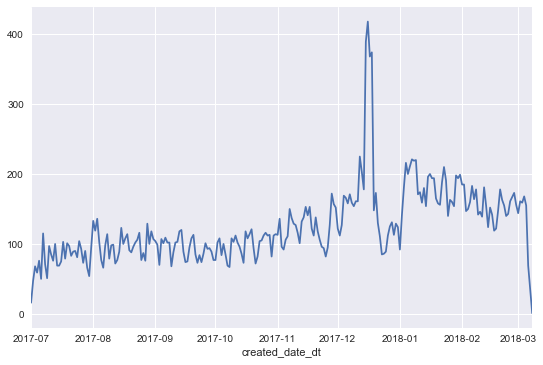

In [26]:
data_merge[data_merge['trial_date'] >= dt.datetime(2017,7,1)].reset_index().groupby(['created_date_dt']).count()['index'].plot()

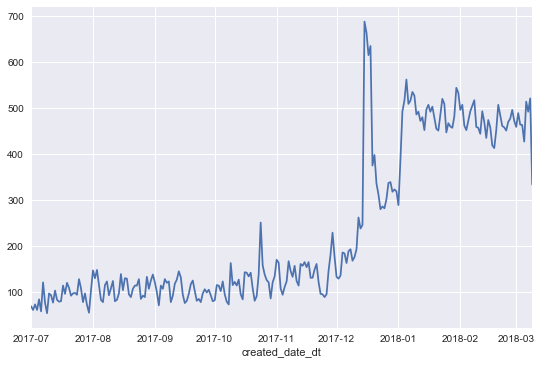

In [27]:
SF_leads[SF_leads['lead_createdate'] >= dt.datetime(2017, 7,1)].groupby('created_date_dt').count()['trial_order_id'].plot()

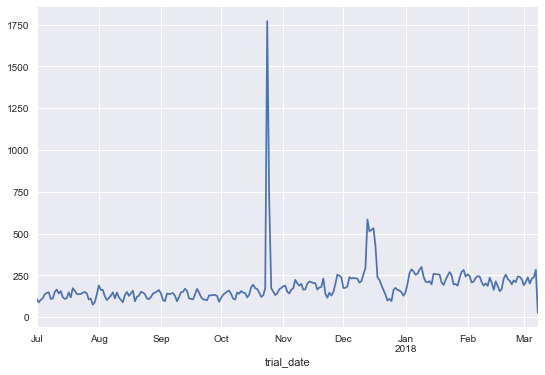

In [28]:
trial_cohort[trial_cohort['trial_date'] >= dt.datetime(2017, 7,1)].groupby('trial_date').count()['tenant_orderid'].plot()

In [29]:
data_merge.to_pickle('raw_merged_data')

<h3>Convert features to dummy variables

In [30]:
data_merge['affiliate_touch'] = data_merge['click_id'].notnull()
data_merge['affiliate_touch'] = data_merge['affiliate_touch'].apply(lambda x: 1 if x else 0)

In [31]:
data_merge.loc[data_merge['Status'] == 'Open','converted'] = 0

In [32]:
data_merge = data_merge[data_merge['trial_date'] < dt.datetime(2018, 2, 1)]

In [33]:
data_merge = data_merge[data_merge['converted'] != 0]

In [34]:
t = ['True','Yes']
data_merge['Have_products'] = data_merge['Have_products__c'].isin(t).apply(lambda x: 1 if x else 0)

In [35]:
cat_var = ['landingPagePath', 'deviceCategory', 'adDistributionNetwork', 'medium', 
           'socialNetwork', 'campaign', 'adKeywordMatchType', 'country_ms', 'Lead_Type__c', 'leadsource', 
 'Lead_Owner_Full_Name__c', 'Device_Type__c', 'Reason_Not_Qualified__c',
       'SMS_Opt_in__c', 'Industry__c', 'SocialSignUp__c', 'Gender__c', 'Position__c']

In [36]:
data_merge.columns

Index(['first_demo_session', 'timestamp', 'date', 'session_id', 'customer_id',
       's_version', 'u_version', 'landingPagePath', 'deviceCategory',
       'adDistributionNetwork', 'adDestinationUrl', 'adwordsAdGroupId',
       'source', 'medium', 'socialNetwork', 'demo_transaction_id', 'u_id',
       'transaction_id', 'campaign', 'adgroup', 'keyword',
       'adKeywordMatchType', 'Creative', 'country_ms', 'click_id',
       'demo_session_position', 'session_date', 'trial_order_detail_id',
       'Lead_Type__c', 'leadsource', 'Lead_Owner_Full_Name__c',
       'Original_Lead_Owner__c', 'Device_Type__c',
       'Number_of_products_selling__c', 'Reason_Not_Qualified__c',
       'SMS_Opt_in__c', 'Timezone_editable__c', 'TimeZone__c', 'Industry__c',
       'SocialSignUp__c', 'Gender__c', 'Last_Login_from_Admin__c',
       'Have_products__c', 'Position__c', 'country', 'Status',
       'lead_createdate', 'converted_to_opp', 'opp_createdate', 'opp_iswon',
       'opp_CloseDate', 'remove', 'cre

In [37]:
for x in cat_var:
    data_merge[x] = data_merge[x].astype('category')

In [38]:
data_merge[['converted','affiliate_touch', 'Have_products', 'session_id_count']].head()

,converted,affiliate_touch,Have_products,session_id_count
2311474,1,0,0,0.0
2313381,-1,1,0,0.0
2313874,-1,0,0,0.0
2314030,-1,1,0,0.0
2314648,1,0,0,0.0


In [39]:
dummies = pd.get_dummies(data_merge[cat_var])

In [40]:
data_dummies = data_merge[['converted', 'affiliate_touch', 'Have_products', 'session_id_count']].join(dummies)

In [41]:
X = np.array(data_dummies[data_dummies.columns[1:]])
Y = np.array(data_dummies['converted'])

In [42]:
data_merge['converted'].describe()

count    25754.000000
mean        -0.866817
std          0.498636
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max          1.000000
Name: converted, dtype: float64

In [43]:
len(data_dummies.columns)

2864

In [44]:
raw_corrs  = [np.corrcoef(X[:, i], Y)[0][1] for i in range(X.shape[1])]

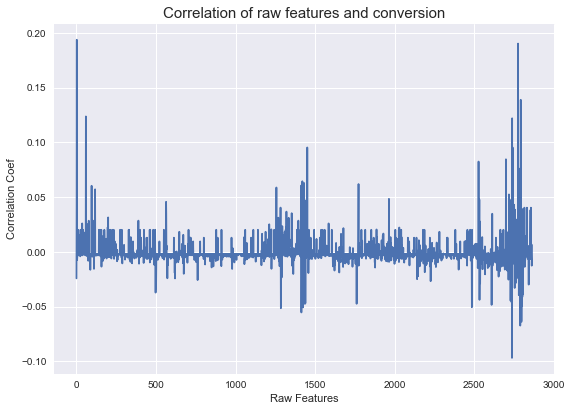

In [47]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Correlation of raw features and conversion', fontsize=15)
ax1.plot(raw_corrs)
ax1.set_xlabel('Raw Features')
ax1.set_ylabel('Correlation Coef')
plt.show()
fig.savefig('rawfeature_correlation.png')



In [48]:
data_dummies.columns[raw_corrs.index(min(raw_corrs))]

'Lead_Type__c_youtube'

In [49]:
data_dummies.columns[raw_corrs.index(max(raw_corrs))]

'Have_products'

<h3>Run PCA

In [51]:
pca = PCA(n_components=200) #set to 100 because we are reducning 2.4K features
pca.fit(X)
pca_X = pca.fit_transform(X)

In [52]:
np.save('pca_features_X', pca_X)
np.save('raw_features_X', X)
np.save('targetdata', Y)

In [53]:
pca_X = np.load('pca_features_X.npy')
X = np.load('raw_features_X.npy')
Y = np.load('targetdata.npy')

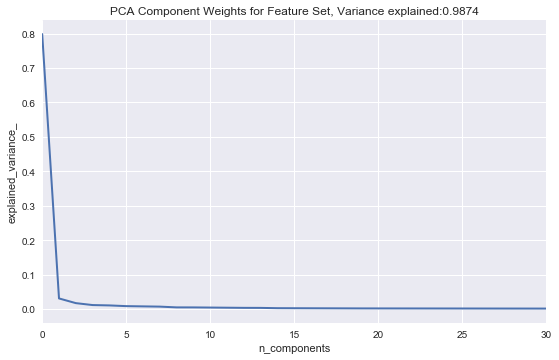

In [65]:
# Plot the PCA spectrum
fig, ax1 = plt.subplots(figsize=(10,6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.title('PCA Component Weights for Feature Set, Variance explained:{}'.format(round(pca.explained_variance_ratio_.sum(), 4)))

plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.xlim([0, 30])

# Prediction
plt.show()
fig.savefig('PCA_explainedvariance')

In [66]:
corrs  = [np.corrcoef(pca_X[:, i], Y)[0][1] for i in range(pca_X.shape[1])]

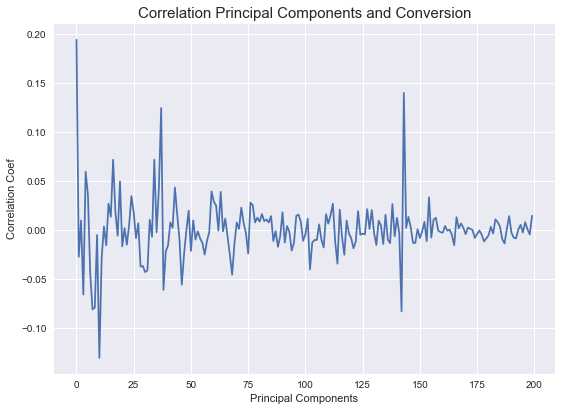

In [67]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Correlation Principal Components and Conversion', fontsize=15)
ax1.plot(corrs)
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('Correlation Coef')
plt.show()
fig.savefig('PCA_explainedvariance.png')


In [68]:
corrs.index(min(corrs))

10

In [69]:
corrs.index(max(corrs))

0

In [70]:
corrs[10]

-0.0049696001455164888

In [75]:
corrs[0]

0.19407049922905201

In [76]:
PCA_matrix = pd.DataFrame(np.array(pca.components_).T, columns =[i for i in range(200)], index= data_dummies.columns[1:])

In [98]:
PCA_matrix.reset_index().to_csv('PCA_weights.csv', encoding='utf-8-sig', index=False)

In [93]:
PCA_matrix.sort_values([0], ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
session_id_count,0.999698,0.010472,-0.002482,0.014575,-0.006848,0.003488,-0.000267,0.007604,0.003681,-0.004664,0.004357,-0.000495,-0.000234,0.001952,-0.000481,0.003200,-0.000375,0.000726,-0.001585,-0.002698,0.001932,0.000635,0.001814,-0.000478,0.000452,-0.000942,0.000219,-0.000155,-0.000178,0.001678,0.001712,0.000511,-0.000963,0.000069,-0.001729,-0.000464,0.002447,-0.001635,0.001267,-0.001342,-0.001736,-0.003705,-0.003616,-0.001424,0.000212,-0.000380,0.001325,-0.001249,-0.000604,0.000207,0.000533,-0.000850,-0.000182,-0.000481,-0.000100,0.000242,0.000148,0.000425,-0.000544,0.000370,-0.000022,-0.000580,0.000195,-0.000261,0.000567,-0.000489,-0.000529,-0.000281,0.000470,0.000383,0.000174,-0.000490,-0.000045,0.000310,-0.000302,-0.000347,0.000264,-0.000311,-0.000011,-0.000014,-0.000949,-0.000229,0.000242,0.000063,0.000152,-0.000183,0.000375,-0.000536,-0.000290,-0.000171,0.000074,0.000222,-0.000156,-0.000217,0.000261,-0.000118,-0.000261,-0.000760,-0.000150,-0.000408,-1.457243e-08,0.000297,-0.000217,-0.000310,0.000371,0.000239,-0.000090,0.000189,0.000384,-0.000032,-0.000303,-0.000076,-0.000094,0.000207,-0.000018,0.000195,0.000135,0.000182,-0.000036,-0.000226,-0.000407,-0.000026,0.000102,-0.000300,0.000304,0.000358,0.000016,-0.000328,0.000096,-0.000181,0.000093,0.000022,-0.000261,0.000027,0.000097,-0.000163,0.000134,-0.000015,-0.000034,0.000067,-0.000050,-0.000042,0.000295,0.000403,0.000003,-0.000261,-0.000058,0.000125,0.000161,0.000212,0.000216,-0.000094,0.000133,-0.000430,-0.000108,0.000071,0.000020,-0.000327,0.000046,0.000162,0.000122,-0.000019,0.000053,-0.000078,0.000095,0.000157,-0.000413,-0.000056,0.000118,0.000110,-0.000245,0.000252,-0.000090,0.000125,0.000366,0.000086,0.000223,-0.000198,-0.000195,0.000013,0.000101,0.000003,-0.000095,-0.000115,0.000058,1.077098e-04,-0.000108,0.000154,0.000041,0.000002,-0.000134,0.000129,0.000030,0.000055,-0.000006,-0.000084,-0.000072,0.000097,0.000016,-0.000213
campaign_(not set),0.008591,-0.319050,-0.060891,-0.077452,0.229073,-0.265070,-0.068012,-0.041948,0.033174,0.128300,-0.265111,-0.149982,-0.112841,-0.014180,-0.227651,0.004923,-0.124119,-0.005274,0.036455,0.093348,-0.002489,-0.039682,-0.071013,0.019753,-0.025575,-0.020375,-0.011121,-0.032548,-0.040603,0.016353,0.013816,0.015630,-0.026097,-0.032374,0.031479,-0.219642,0.137999,0.061844,-0.078955,-0.190980,-0.178679,0.010796,0.120968,0.029383,0.016268,0.083226,-0.071792,0.059364,-0.035526,-0.010418,0.003312,0.075911,0.142139,0.057978,-0.090628,0.013487,-0.024276,0.071340,0.071985,-0.072290,0.012766,-0.024879,-0.007331,-0.015346,0.099538,-0.195843,0.098451,-0.049649,0.007073,0.011933,0.009170,0.008253,-0.030610,-0.017173,0.012134,0.019000,-0.028478,-0.011906,-0.004613,0.037938,-0.048441,-0.014519,0.029640,-0.007761,0.008936,-0.005819,-0.009277,0.009815,0.044952,-0.006592,-0.027361,-0.000142,0.008174,-0.005182,-0.002385,0.003437,-0.002933,-0.003028,-0.000720,0.016423,5.588704e-03,0.015437,0.007364,0.013890,-0.005954,-0.005702,0.006430,-0.003379,0.020515,-0.021419,-0.103582,-0.028202,-0.042800,0.028854,-0.002094,0.001556,-0.012580,-0.016369,-0.006638,-0.007557,0.008114,-0.000426,-0.004355,0.020902,-0.026106,-0.004940,-0.007441,-0.039114,0.003731,-0.009366,0.005284,-0.038215,-0.127819,0.011345,0.012981,-0.031046,0.018145,-0.011792,-0.007880,0.001275,-0.000683,0.007190,0

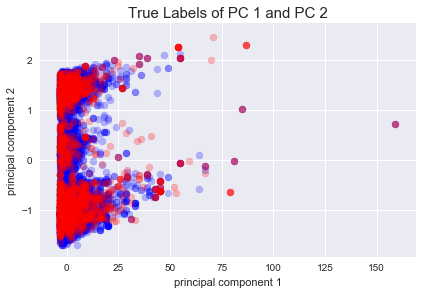

In [79]:
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.set_title('True Labels of PC 1 and PC 2', fontsize=15)

plt.scatter(pca_X[np.where(Y[:] == -1), 0],pca_X[np.where(Y[:] == -1), 1], color='blue', alpha = 0.25)
plt.scatter(pca_X[np.where(Y[:] == 1), 0],pca_X[np.where(Y[:] == 1), 1], color='red', alpha = 0.25)

ax1.set_xlabel('principal component 1')
ax1.set_ylabel('principal component 2')
plt.show()
fig.savefig('PC1_PC2_truelabels.png')

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import itertools

In [81]:
X_train, X_test, y_train, y_test = train_test_split(pca_X, Y, test_size = 0.4, random_state = 4)

In [82]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
cv_score = cross_val_score(lr, X_train, y_train, cv=10)

In [84]:
cv_score.mean()

0.92612173785014051

In [85]:
y_train[np.where(y_train[:] == 1)].sum()

1351

In [86]:
y_train[np.where(y_train[:] == 1)].sum()*1.0/len(y_train)

0.082418252806246955

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[14923   118]
 [ 1059   292]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.78  0.22]]


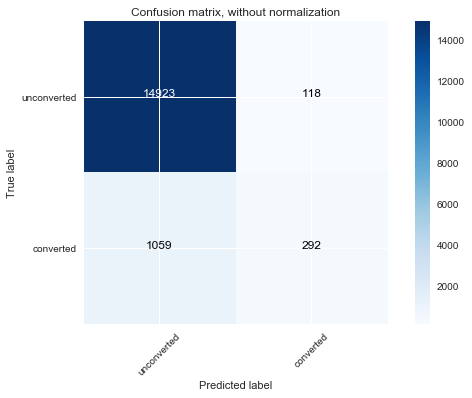

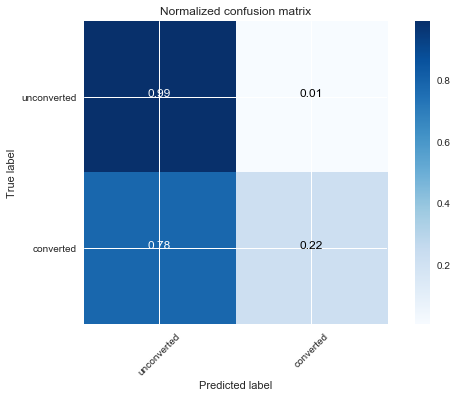

In [88]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, lr.predict(X_train))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
f1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['unconverted', 'converted'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
f2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['unconverted', 'converted'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()
f1.savefig('logreg_confusion_matrix_total.png')
f1.savefig('logreg_confusion_matrix_norm.png')